### The purpose of this notebook is to test the AUC of a "dumb" classifier, which classifies abnormal (1) in the middle x% of the video, and normal (0) otherwise.

In [1]:
import os
# import json
# import pickle
# import glob
import numpy as np
from scipy.ndimage import gaussian_filter1d
# import matplotlib.pyplot as plt
# %matplotlib inline

from sklearn.metrics import roc_auc_score

In [2]:
def get_gt():
    dataset_gt_arr = []
    num_frames_arr = []
    per_frame_scores_root = 'data/testing/test_frame_mask_orig/'
    clip_list = os.listdir(per_frame_scores_root)
    clip_list = sorted(fn for fn in clip_list if fn.endswith('.npy'))
    # print("Scoring {} clips".format(len(clip_list)))
    for clip in clip_list:
        clip_res_fn = os.path.join(per_frame_scores_root, clip)
        clip_gt = np.load(clip_res_fn)
        dataset_gt_arr.append(clip_gt)
        
        num_frames = clip_gt.shape[0]
        num_frames_arr.append(num_frames)
        
    gt_np = np.concatenate(dataset_gt_arr)
    num_frames_np = np.array(num_frames_arr)
    
    return gt_np, num_frames_np

In [3]:
gt_np, num_frames_np = get_gt()
num_frames_np

array([265, 433, 337, 601, 505, 409, 457, 313, 409, 337, 337, 457, 577,
       313, 529, 193, 289, 289, 265, 241, 337, 289, 265, 217, 433, 409,
       529, 313, 217, 241, 313, 193, 265, 317, 457, 337, 361, 529, 409,
       313, 385, 457, 481, 457, 433, 385, 241, 553, 937, 865, 505, 313,
       361, 361, 529, 337, 433, 481, 649, 649, 409, 337, 769, 433, 241,
       217, 265, 265, 217, 265, 409, 385, 481, 457, 313, 601, 241, 481,
       313, 337, 457, 217, 241, 289, 337, 313, 337, 265, 265, 337, 361,
       433, 241, 433, 601, 505, 337, 601, 265, 313, 241, 289, 361, 385,
       217, 337, 265])

In [8]:
def auc_per_frac2(frac, frac2, gt_np, num_frames_np):
    
    dataset_scores_arr = []
    for num_frames in num_frames_np:
        # num_frames_normal = int ( (1 - frac) / 2 * num_frames )
        
        num_frames_normal = int ( (1 - frac) * num_frames )
        num_frames_start = int(      frac2  * num_frames_normal )
        num_frames_end   = int( (1 - frac2) * num_frames_normal )
        
        clip_score = np.zeros(num_frames)
        clip_score[num_frames_start : -num_frames_end] = 1.0

        dataset_scores_arr.append(clip_score)

    scores_np = np.concatenate(dataset_scores_arr)
    scores_smoothed = gaussian_filter1d(scores_np, sigma=40)
    
    # auc = roc_auc_score(gt_np, scores_np)
    auc = roc_auc_score(gt_np, scores_smoothed)
    
    return auc, scores_np, scores_smoothed

In [5]:
d = {}
# frac2 = 0.6
# for frac in np.arange(0.45, 0.56, 0.01):
frac2 = 0.6 # frac2 = 0.6 0.27: 0.7718053730496561
for frac in np.arange(0.15, 0.86, 0.01):
    # print(frac, type(frac))
    # d[frac] = auc_per_frac(frac, gt_np, num_frames_np)
    d[frac] = auc_per_frac2(frac, frac2, gt_np, num_frames_np)
    
d

{0.15: 0.7691560916825462,
 0.16: 0.7699338162680687,
 0.17: 0.7700533561802856,
 0.18000000000000002: 0.7703426998573549,
 0.19000000000000003: 0.7705546517135621,
 0.20000000000000004: 0.7707096591874661,
 0.21000000000000005: 0.7708900064318546,
 0.22000000000000006: 0.7712564578350967,
 0.23000000000000007: 0.7713419555784624,
 0.24000000000000007: 0.7715907893205682,
 0.2500000000000001: 0.7714230025050266,
 0.2600000000000001: 0.7715693678430736,
 0.27000000000000013: 0.7718053730496561,
 0.28000000000000014: 0.7715065005169417,
 0.29000000000000015: 0.7716267758777487,
 0.30000000000000016: 0.7714965805699058,
 0.31000000000000016: 0.7712605421574505,
 0.3200000000000002: 0.7711705394840088,
 0.3300000000000002: 0.7709053709121818,
 0.3400000000000002: 0.7707718045933265,
 0.3500000000000002: 0.770478880831231,
 0.3600000000000002: 0.7701162087482519,
 0.3700000000000002: 0.7698701335532825,
 0.3800000000000002: 0.7696786229863989,
 0.39000000000000024: 0.7691215711031574,
 0.40

In [11]:
frac  = 0.27
frac2 = 0.6
auc, scores_np, scores_smoothed = auc_per_frac2(frac, frac2, gt_np, num_frames_np)
auc

0.7718053730496561

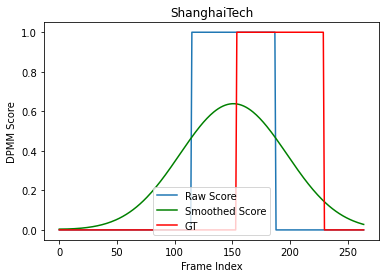

In [28]:
def plot_graphs(plots: dict, vid_out_path):
    import matplotlib.pyplot as plt

    dirname = os.path.dirname(vid_out_path)
    filename = os.path.basename(vid_out_path)

    # plot raw score
    clip_score = plots['raw_scores'] # scores_np[start_frames[i]:end_frames[i]]    
    plt.plot(np.arange(len(clip_score)), clip_score, label='Raw Score')
    
    # plot smoothed score    
    scores_smoothed = plots['smoothed_scores']
    plt.plot(np.arange(len(scores_smoothed)), scores_smoothed, 'g', label='Smoothed Score')
    
    # plot gt    
    gt = plots['gt']
    plt.plot(np.arange(len(gt)), gt, 'r', label='GT')
        
    plt.legend(loc = 'lower center')    
    plt.xlabel('Frame Index')
    plt.ylabel('DPMM Score')
    plt.title(filename)
    # plt.savefig(os.path.join(dirname, filename[:-4] + '.png'))
    plt.show()
    
plots = {'raw_scores': scores_np[0:265], 'smoothed_scores': scores_smoothed[0:265], 'gt': gt_np[0:265]}
plot_graphs(plots, 'ShanghaiTech')    

In [26]:
end_frames = np.cumsum(num_frames_np)
start_frames = end_frames[:-1]
start_frames = np.insert(start_frames, 0, 0)
print(start_frames)
print(end_frames)

[    0   265   698  1035  1636  2141  2550  3007  3320  3729  4066  4403
  4860  5437  5750  6279  6472  6761  7050  7315  7556  7893  8182  8447
  8664  9097  9506 10035 10348 10565 10806 11119 11312 11577 11894 12351
 12688 13049 13578 13987 14300 14685 15142 15623 16080 16513 16898 17139
 17692 18629 19494 19999 20312 20673 21034 21563 21900 22333 22814 23463
 24112 24521 24858 25627 26060 26301 26518 26783 27048 27265 27530 27939
 28324 28805 29262 29575 30176 30417 30898 31211 31548 32005 32222 32463
 32752 33089 33402 33739 34004 34269 34606 34967 35400 35641 36074 36675
 37180 37517 38118 38383 38696 38937 39226 39587 39972 40189 40526]
[  265   698  1035  1636  2141  2550  3007  3320  3729  4066  4403  4860
  5437  5750  6279  6472  6761  7050  7315  7556  7893  8182  8447  8664
  9097  9506 10035 10348 10565 10806 11119 11312 11577 11894 12351 12688
 13049 13578 13987 14300 14685 15142 15623 16080 16513 16898 17139 17692
 18629 19494 19999 20312 20673 21034 21563 21900 22333 2

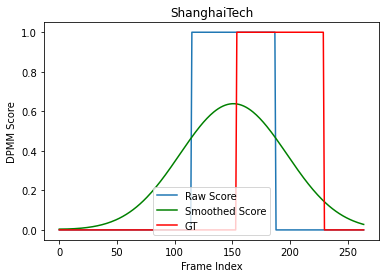

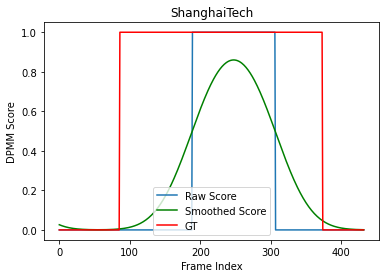

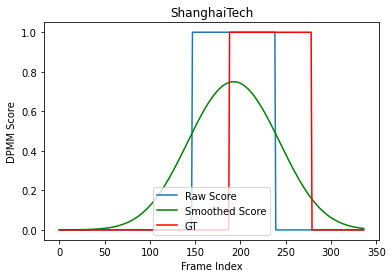

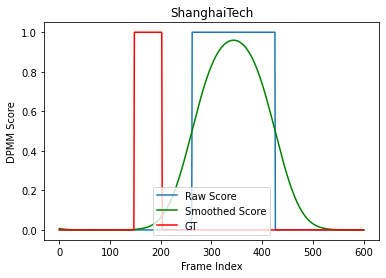

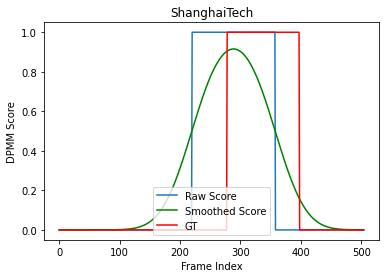

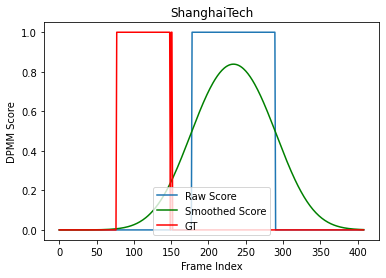

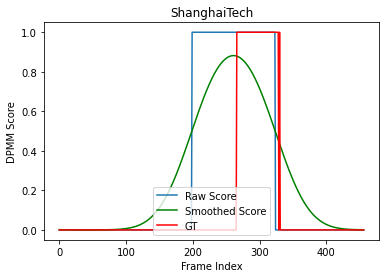

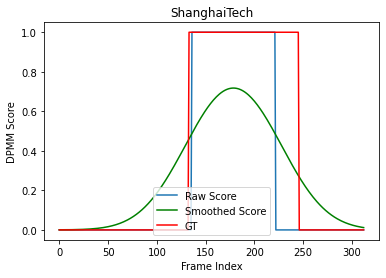

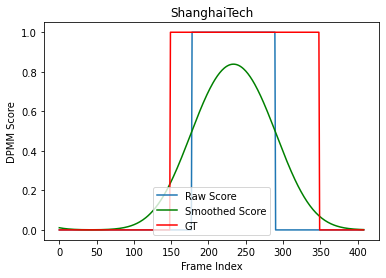

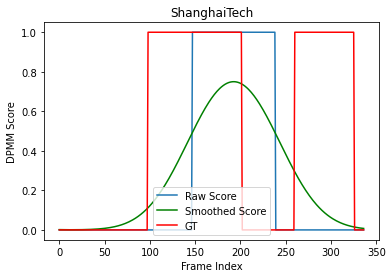

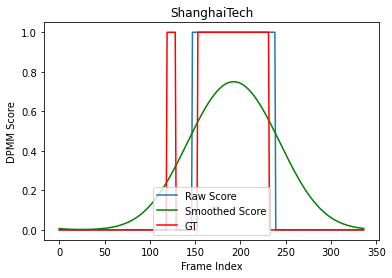

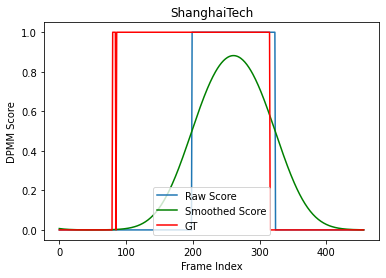

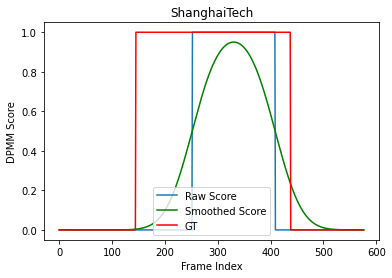

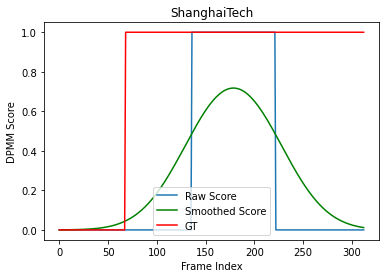

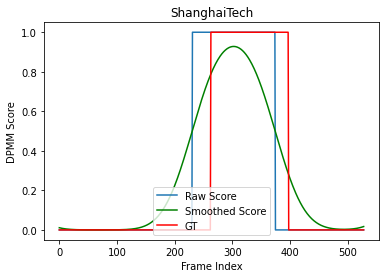

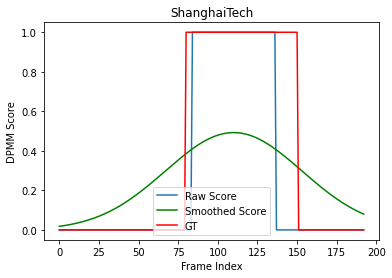

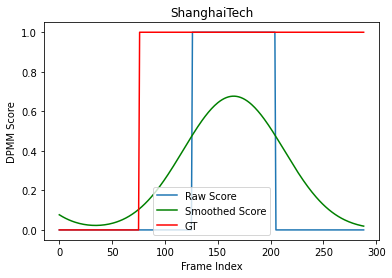

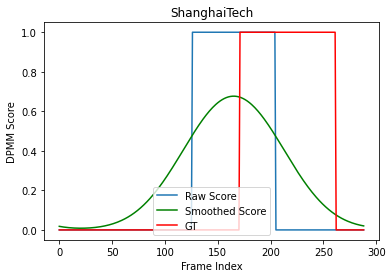

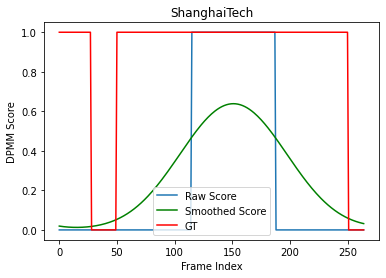

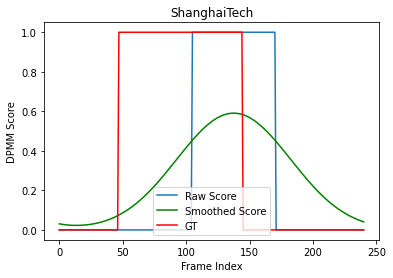

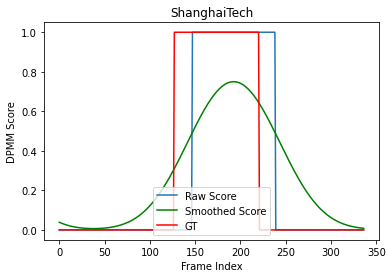

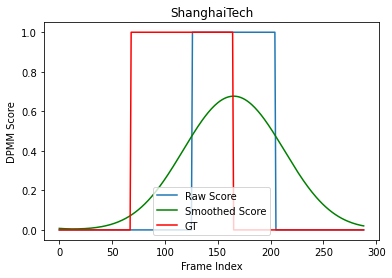

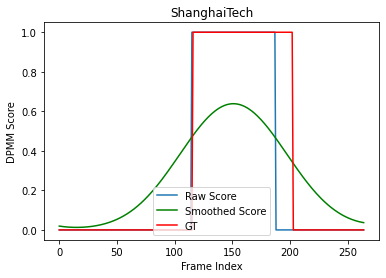

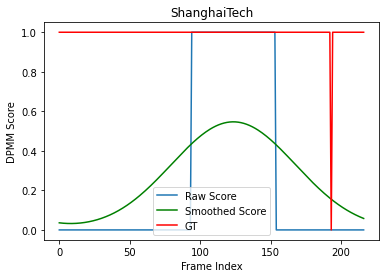

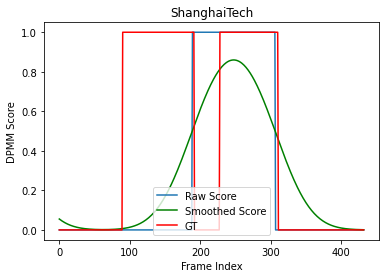

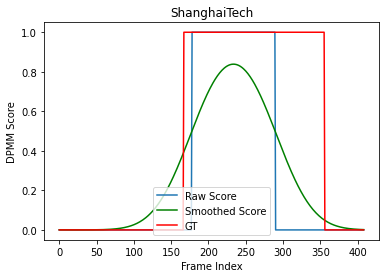

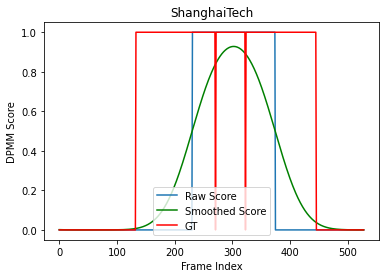

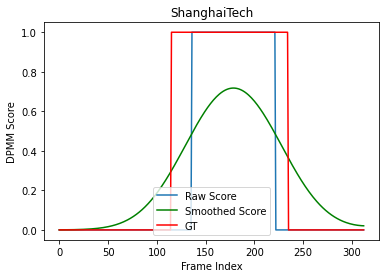

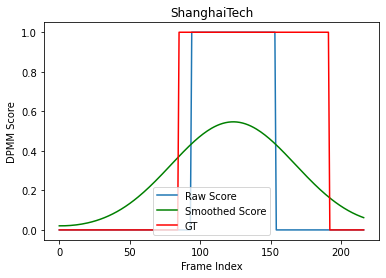

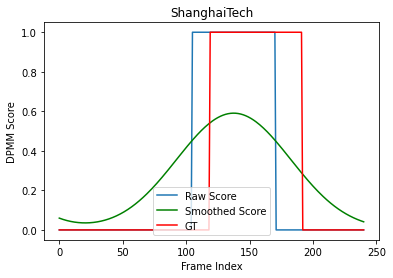

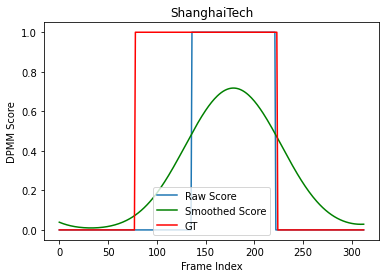

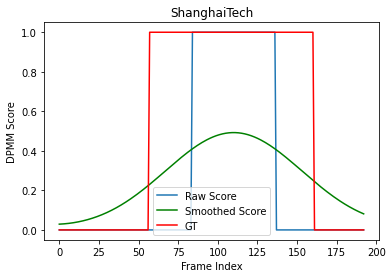

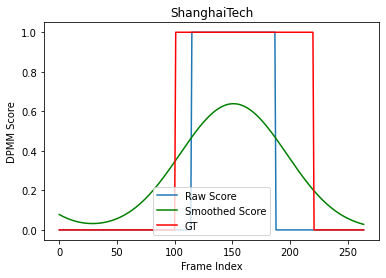

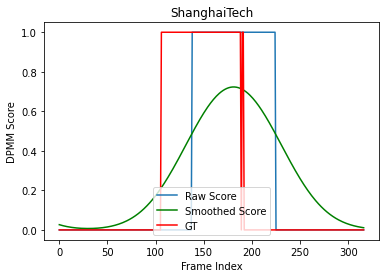

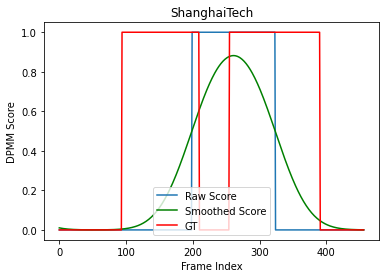

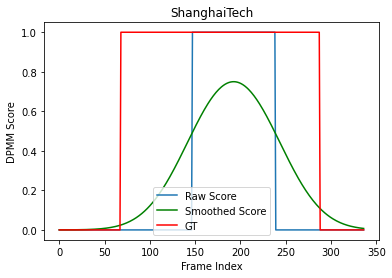

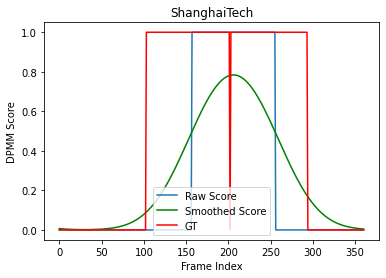

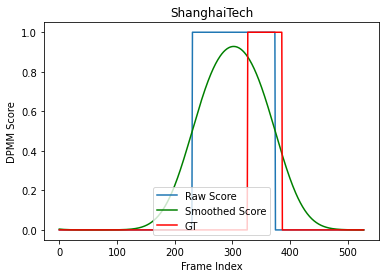

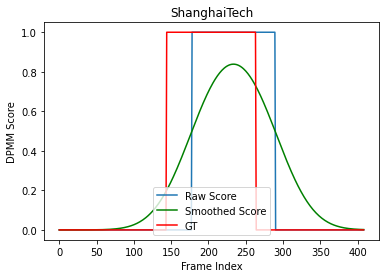

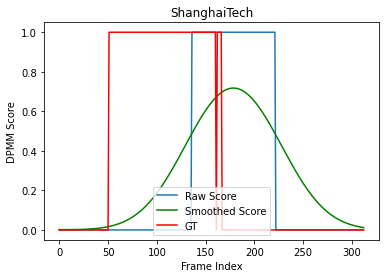

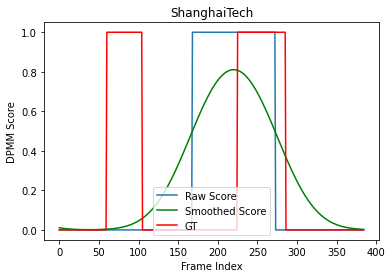

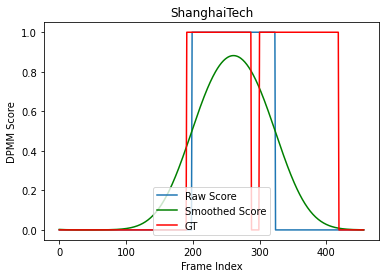

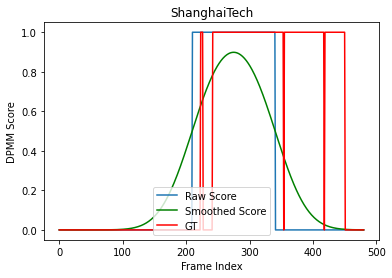

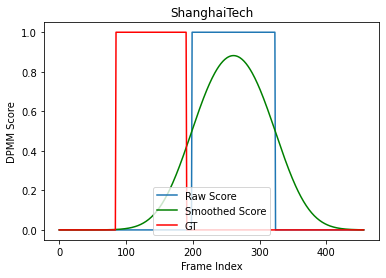

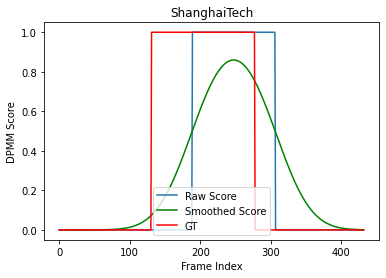

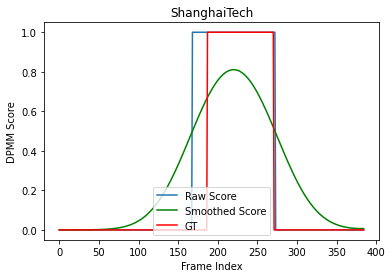

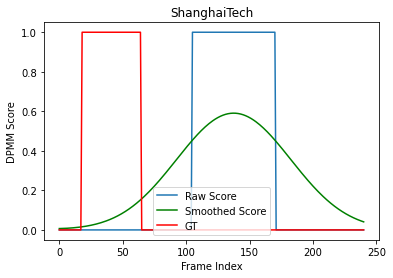

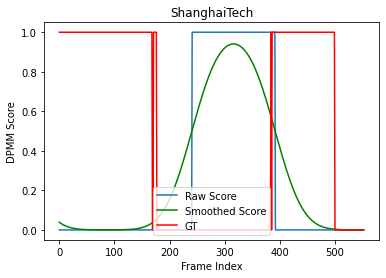

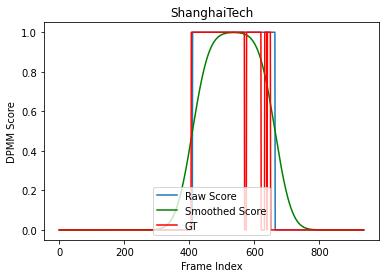

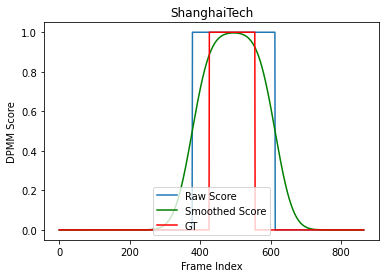

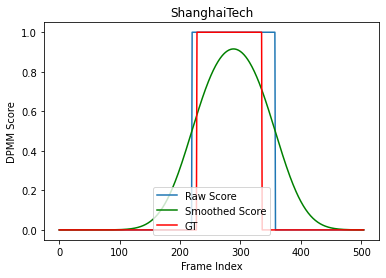

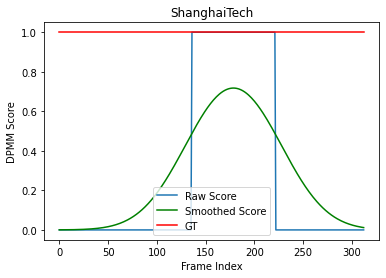

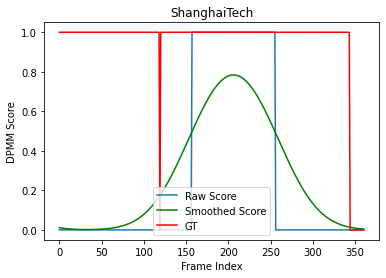

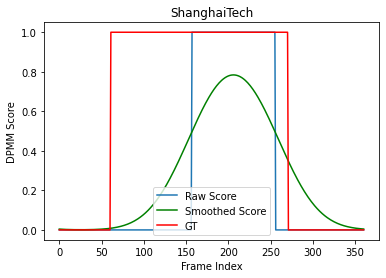

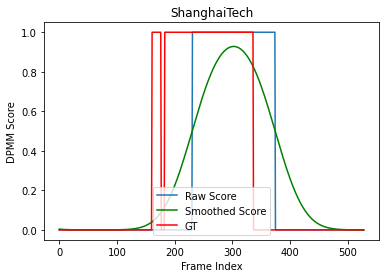

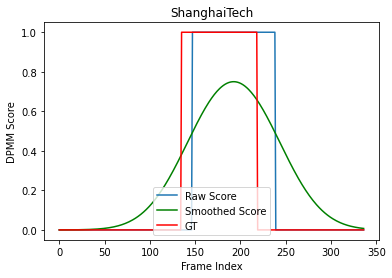

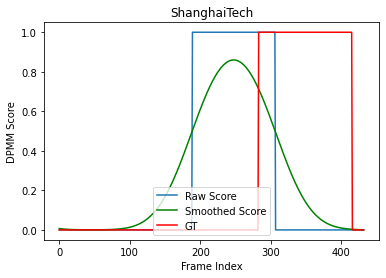

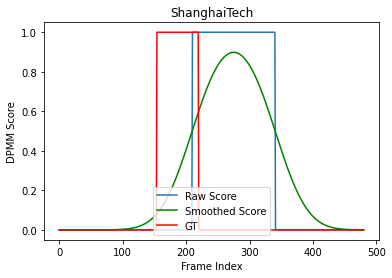

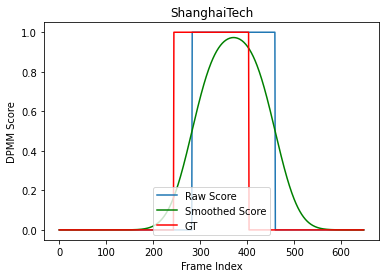

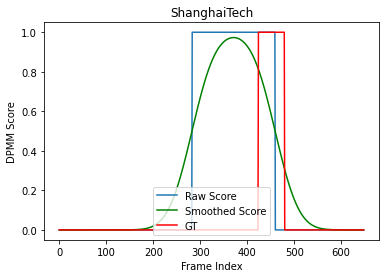

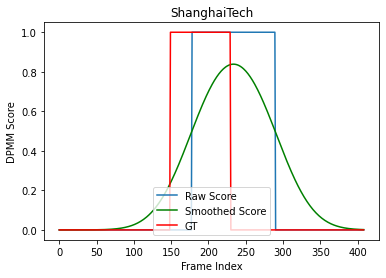

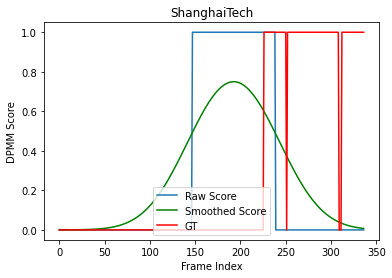

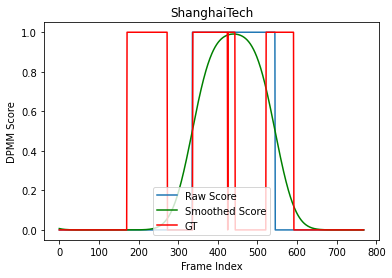

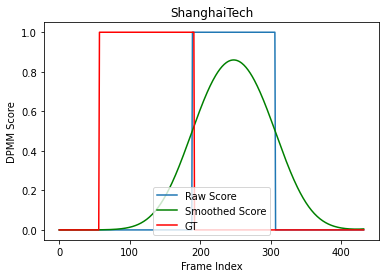

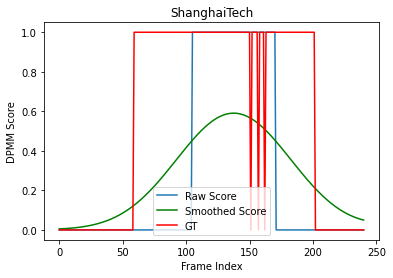

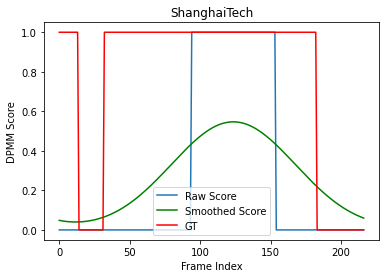

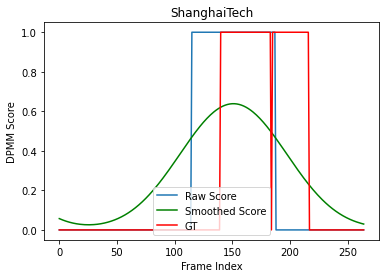

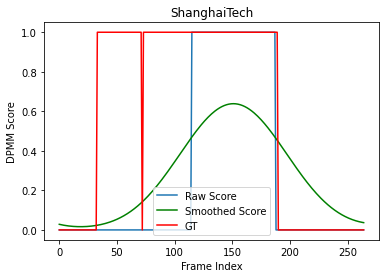

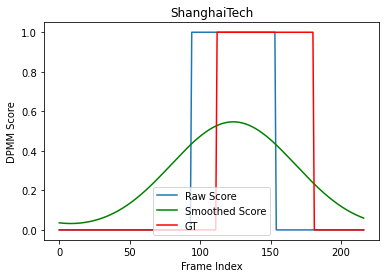

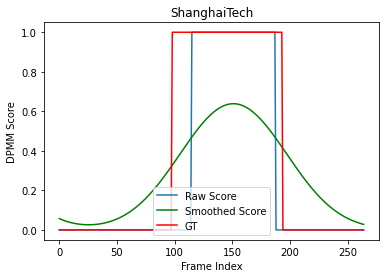

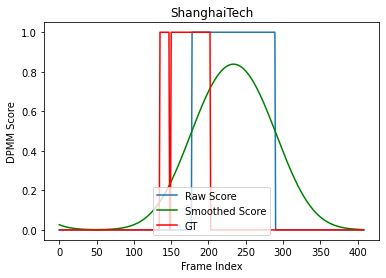

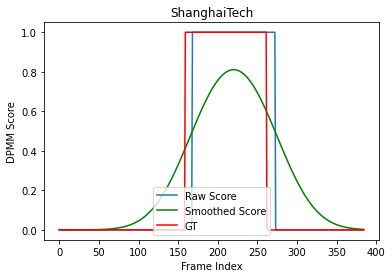

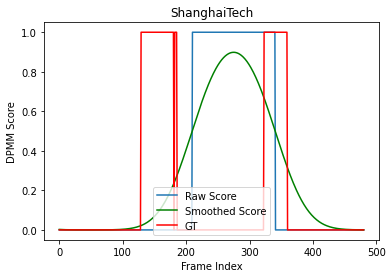

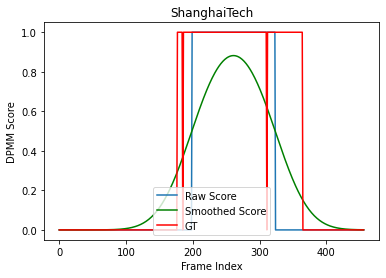

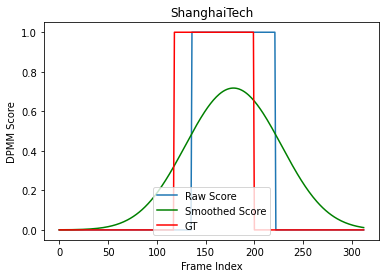

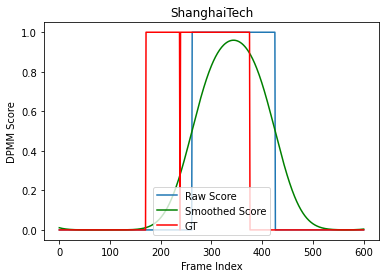

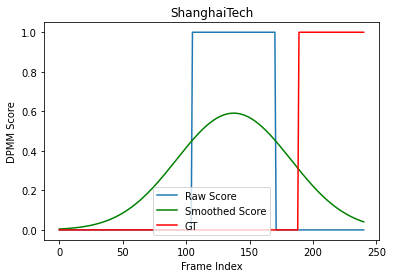

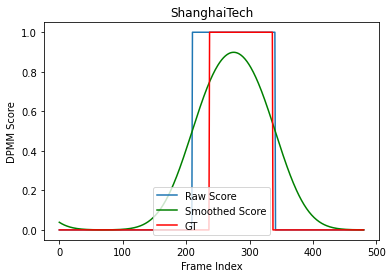

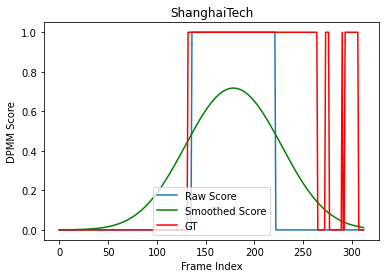

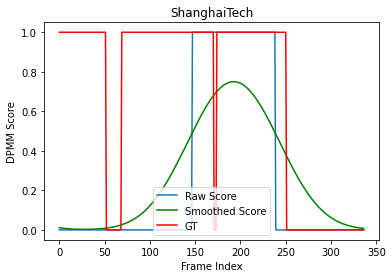

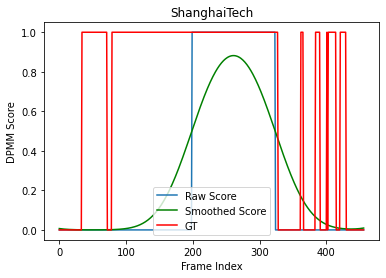

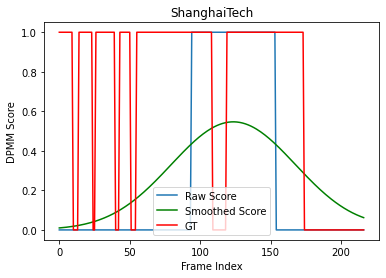

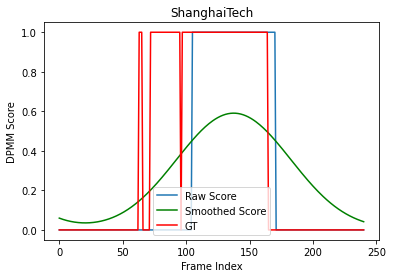

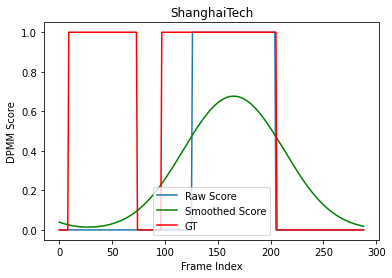

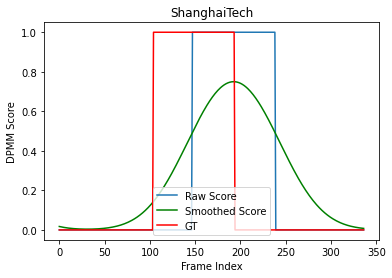

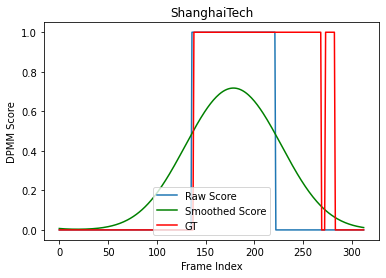

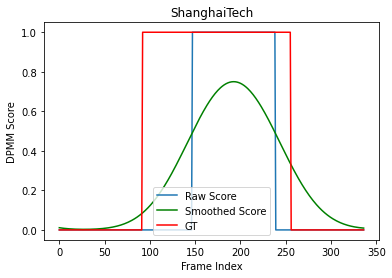

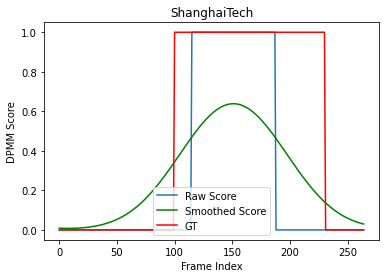

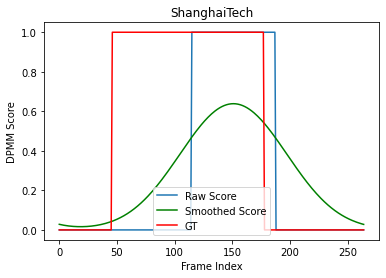

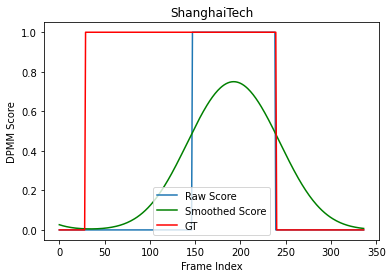

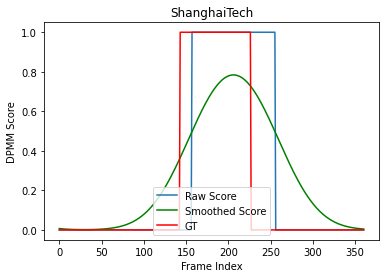

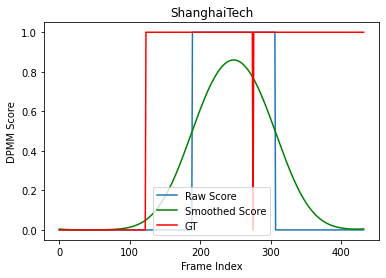

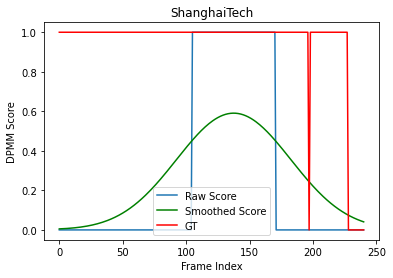

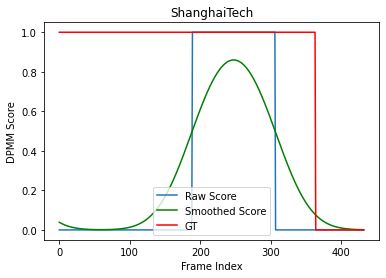

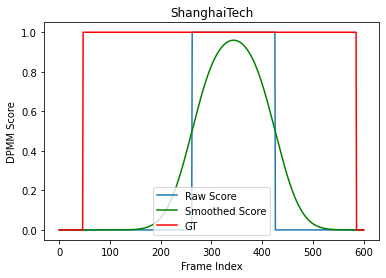

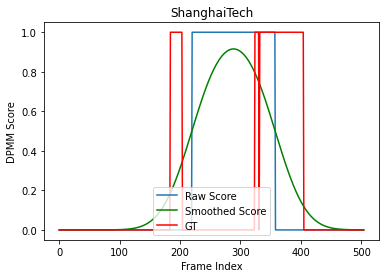

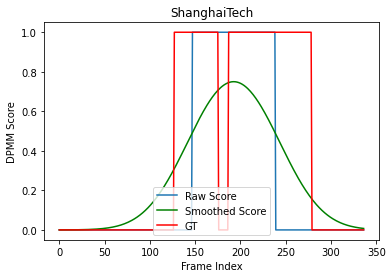

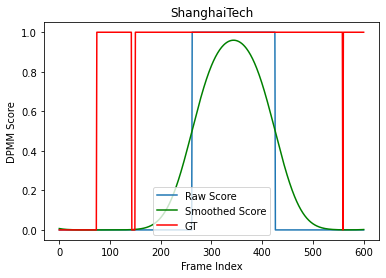

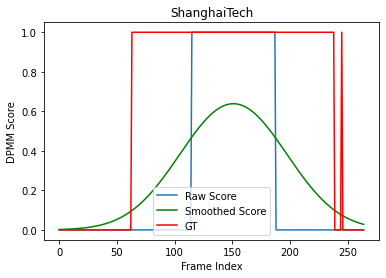

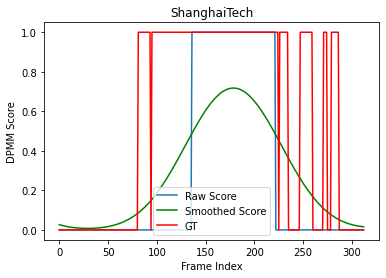

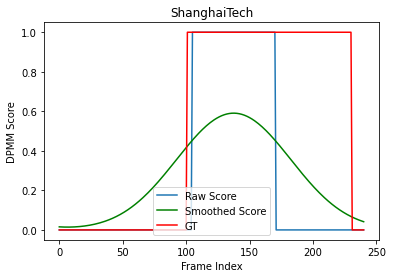

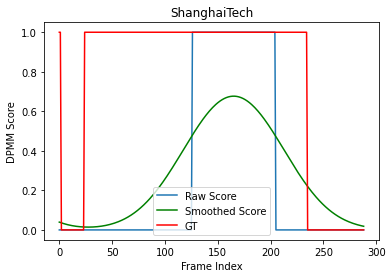

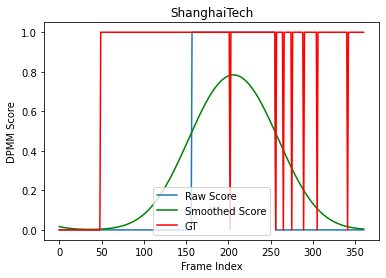

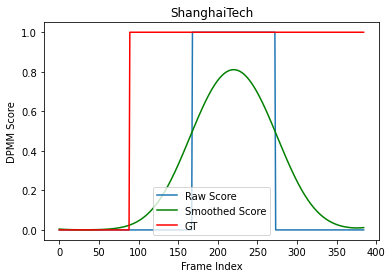

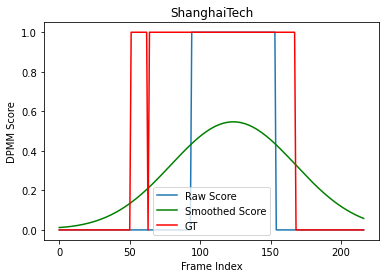

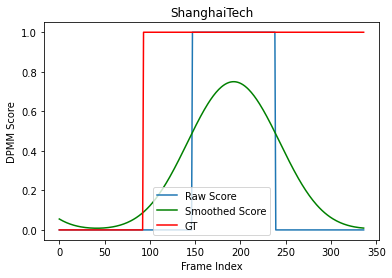

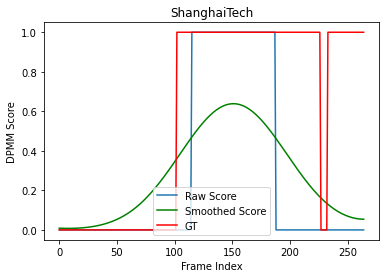

In [29]:
for start_frame, end_frame in zip(start_frames, end_frames):
    plots = {'raw_scores': scores_np[start_frame:end_frame], 'smoothed_scores': scores_smoothed[start_frame:end_frame], 'gt': gt_np[start_frame:end_frame]}
    plot_graphs(plots, 'ShanghaiTech')

### END

In [6]:
# def auc_per_frac(frac):
#     dataset_gt_arr = []
#     dataset_scores_arr = []
#     per_frame_scores_root = 'data/testing/test_frame_mask_orig/'
#     clip_list = os.listdir(per_frame_scores_root)
#     clip_list = sorted(fn for fn in clip_list if fn.endswith('.npy'))
#     # print("Scoring {} clips".format(len(clip_list)))
#     for clip in clip_list:
#         clip_res_fn = os.path.join(per_frame_scores_root, clip)
#         # print(clip_res_fn)
#         clip_gt = np.load(clip_res_fn)
#         # scores_zeros = np.zeros(clip_gt.shape[0])
#         # print(clip_gt, type(clip_gt), clip_gt.shape, )
#         num_frames = clip_gt.shape[0]
#         num_frames_normal = int ( (1 - frac) / 2 * num_frames )
#         # print(num_frames, num_frames_normal)
#         clip_score = np.zeros(num_frames)
#         clip_score[num_frames_normal : -num_frames_normal] = 1.0
#         # print(clip_score)
# 
#         dataset_gt_arr.append(clip_gt)
#         dataset_scores_arr.append(clip_score)
# 
#         # print(len(clip_gt), num_frames, len(clip_score))
# 
#     gt_np = np.concatenate(dataset_gt_arr)
#     scores_np = np.concatenate(dataset_scores_arr)
# 
#     auc = roc_auc_score(gt_np, scores_np)
#     
#     return auc

In [7]:
# d = {}
# # for frac in np.arange(0.2, 0.95, 0.05):
# for frac in np.arange(0.4, 0.51, 0.01):
#     # print(frac, type(frac))
#     d[frac] = auc_per_frac(frac)
#     
# d    